# Get user info 

In this notebook we'll explore some user groups of interest. We will take two approaches.
1. Look at user groups around specific channels and look into their histories.
2. Look at user groups around certain topics and look into their histories.

Let's start with importing the required python libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 
import csv 
import re
import datetime as dt
import sys
import os

%matplotlib inline
csv.field_size_limit(sys.maxsize)


131072

Set paths to data. Better to set these paths into a separate config file.

In [2]:
# Set path to data from Dutch channels.

path_nl = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/NL/'

# Set path to data from right wing channels.

path_right = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/right/'

# Set path to data from left wing channels.

path_left = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/left/'

# Set path to users

path_users = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/users/'

IMPORTANT NOTE: some data is really messy, especially the comment data. I had a hard time parsing the data correctly. One of the solutions was to use rare characters as separators and quotechars. 
In this case, I mostly used:

- sep='¶'
- quotechar='þ'

You need to use the python engine when reading csv, because the C engine doesn't accept these kinds of delimiters.

## Merge channels and comments so we can select the users of interest

In [12]:
nl_comments = pd.read_csv(path_nl + 'comments_nl_right.csv',
                        sep='¶',
                        quotechar='þ',
                        engine='python')

In [13]:
nl_videos = pd.read_csv(path_nl + 'videos_nl_right.csv')

In [14]:
nl_comment_sphere = pd.merge(nl_comments, nl_videos, on='video_id', how='left')

So these are the channels in our Dutch right infosphere and the number of comments we found per channel

In [197]:
nl_comment_sphere.drop_duplicates()
nl_comment_sphere.video_channel_title.value_counts()


Omroep PowNed                      455272
GeenStijl                           65891
Rafiek de Bruin                     44645
Forum Democratie                    30290
Cafe Weltschmerz                    26387
Paul Nielsen                        19938
Linkse Moskee                       15463
Laurens                             15378
Leukste YouTube fragmenten          15251
TheLvkrijger                        15140
LaVieJanRoos                        11060
Brave New World                     10010
Deweycheatumnhowe                    9995
PolitiekincorrectTV                  8083
AvariceUntied                        7722
Voice of Europe                      5928
GeertWildersMedia                    4738
Matthew & Doris                      4692
Keihard Producties                   3621
ThePostOnline TPO                    3433
PVVpers                              3181
PVV Media                            3098
Pim Fortuyn                          2375
Al Stankard aka HAarlem VEnison   

So most comments were made on Omroep PowNed and GeenStijl (btw they have an insane amount of videos), but I would argue to leave these channels out of the analysis voor now. Rafiek de Bruin (38348), followed by Forum voor Democratie and Paul Nielsen are then the most prolific channels.

This is also a good overview of the available channels.

TODO: add more channels and delete some (Matthew & Doris, Al Stankard and Voice of Europe)

## Select a user group based on a channel

1. Erkenbrand
2. Forum voor Democratie
3. PVVpers
4. NVU? 

In [198]:
# how do you want to name the channel?

name = 'Erkenbrand'

# What is the exact name of the channel in the channel file?
    
channel = 'Erkenbrand Kanaal'

directory = path_users + name + "/"

if not os.path.exists(directory):
    os.makedirs(directory)

Filter out the users from the comments and put them into a set (for performance better than a list)

In [199]:
nl_comment_selection = nl_comment_sphere[nl_comment_sphere['video_channel_title'] == channel]

In [200]:
# Sort values on time

nl_comment_selection = nl_comment_selection.sort_values('comment_time')

In [201]:
# Write comments to csv

nl_comment_selection.to_csv(directory + name + '_all_comments.csv')

In [202]:
# Get a sense of how many individuals have been commenting on the channel

users = nl_comment_selection.author_channel_id.unique().tolist()
users = set(users)
len(users)

159

This file is worth checking out. Let's pick the users that are of interest. For instance, pick the users with a Dutch sounding name. Or look at the users in the comment file of the channel (all_comments_on_{name of the channel}.csv)

In [203]:
# Write a list of most prolific commenters to csv

prolific_users = nl_comment_selection.author_display_name.value_counts()
prolific_users.to_csv(directory + name + '_most_prolific_commenters.csv', index=True)

## See other channels where our users are commenting, starting with NL right infosphere

In [204]:
users_in_nl = nl_comment_sphere[nl_comment_sphere['author_channel_id'].isin(users)]
users_in_nl = users_in_nl.sort_values('comment_time')
len(users_in_nl)

3914

In [205]:
# Write to csv

users_in_nl.to_csv(directory + name + '_commenters_in_nl_sphere.csv')

Now get some statistics and find some top commenters in the dutch right infosphere

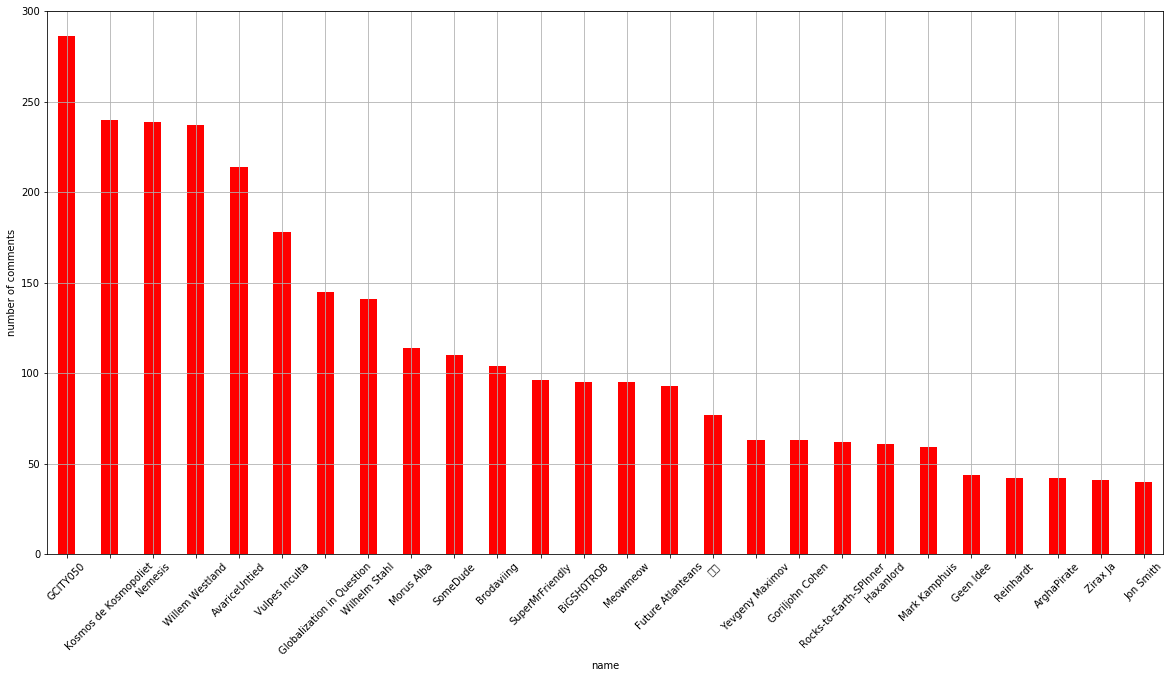

In [206]:
topcommenters = users_in_nl.author_display_name.value_counts()
topcommenters_to_plot = topcommenters[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topcommenters_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

So these are the users of the channel we are interested in and how much they have commented on channels of the international right infosphere. Let's write this to a csv_file. 

In [207]:
topcommenters.to_csv(directory + name + '_most_prolific_commenters_in_dutch_infosphere.csv', index=True)

Look at the most popular channels of this group.

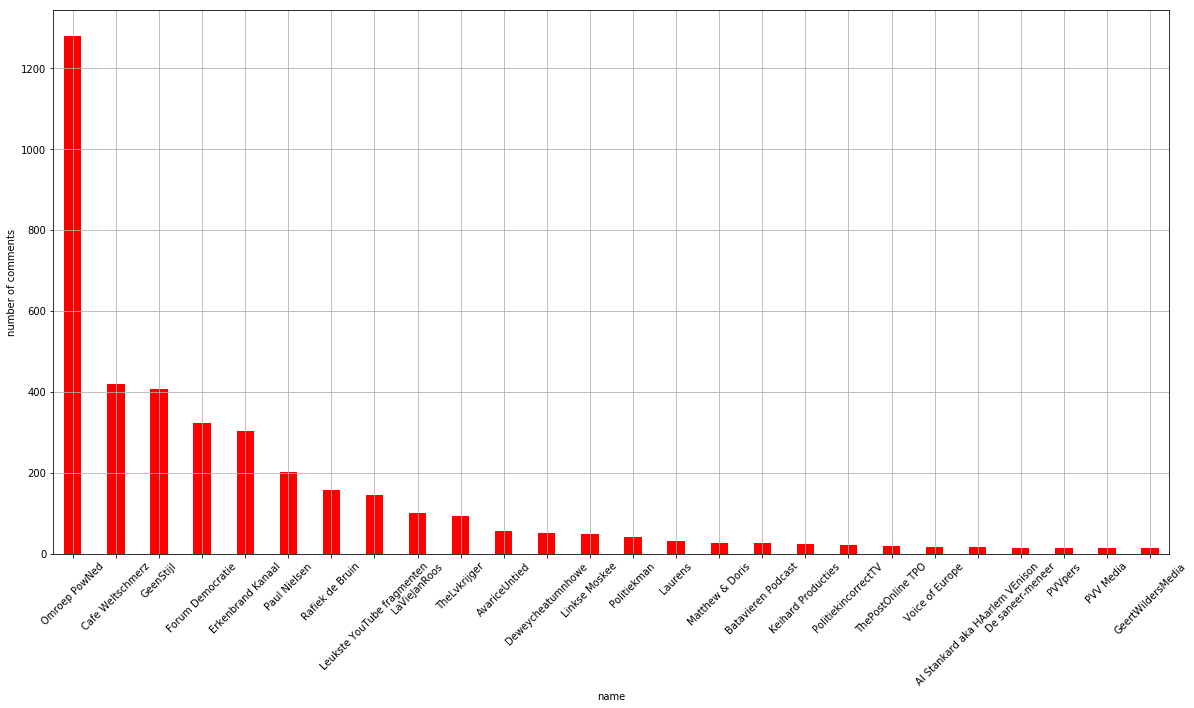

In [208]:
topchannels = users_in_nl.video_channel_title.value_counts()
topchannels_to_plot = topchannels[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topchannels_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

So here we see the most popular channels of our user group. Let's write this list to a csv as well.

In [209]:
topchannels.to_csv(directory + name + '_most_popular_channels_in_dutch_infosphere.csv', index=True)

## Our users in the international right infosphere

In [210]:
# Run our list of users through the international right infosphere. The international comment file is very
# large so we need to load it in chunks.

In [211]:
column_names = ['video_id',
      'comment_id',
      'author_display_name',
      'author_channel_url',
      'author_channel_id',
      'comment_text',
      'comment_like_count',
      'comment_dislike_count',
      'comment_time',
      'reply_count']


iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        names=column_names,
                        sep='¶',
                        quotechar='þ',
                        engine='python')
nl_int_right_infosphere = pd.concat([chunk[chunk['author_channel_id'].isin(users)] for chunk in iter_csv])

# And see how many comments we found of our users
len(nl_int_right_infosphere)

33913

In [212]:
column_names = ['video_id',
                      'video_published',
                      'channel_id',
                      'video_title',
                      'video_description',
                      'video_channel_title',
                      'video_tags',
                      'video_category_id',
                      'video_default_language',
                      'video_duration',
                      'video_view_count',
                      'video_comment_count',
                      'video_likes_count',
                      'video_dislikes_count',
                      'video_topic_ids',
                      'video_topic_categories']



In [213]:
videos_right = pd.read_csv('output/right/videos_right.csv', 
                            names=column_names,
                            sep='¶',
                            quotechar='þ',
                            engine='python'
                            ) 
users_in_int_right = pd.merge(nl_int_right_infosphere, videos_right, on='video_id', how='left')


Write all the comments of our users to a csv

In [214]:
users_in_int_right.to_csv(directory + name + '_commenters_in_int_right_infosphere.csv')

Now get some statistics and find some top commenters in the international right infosphere

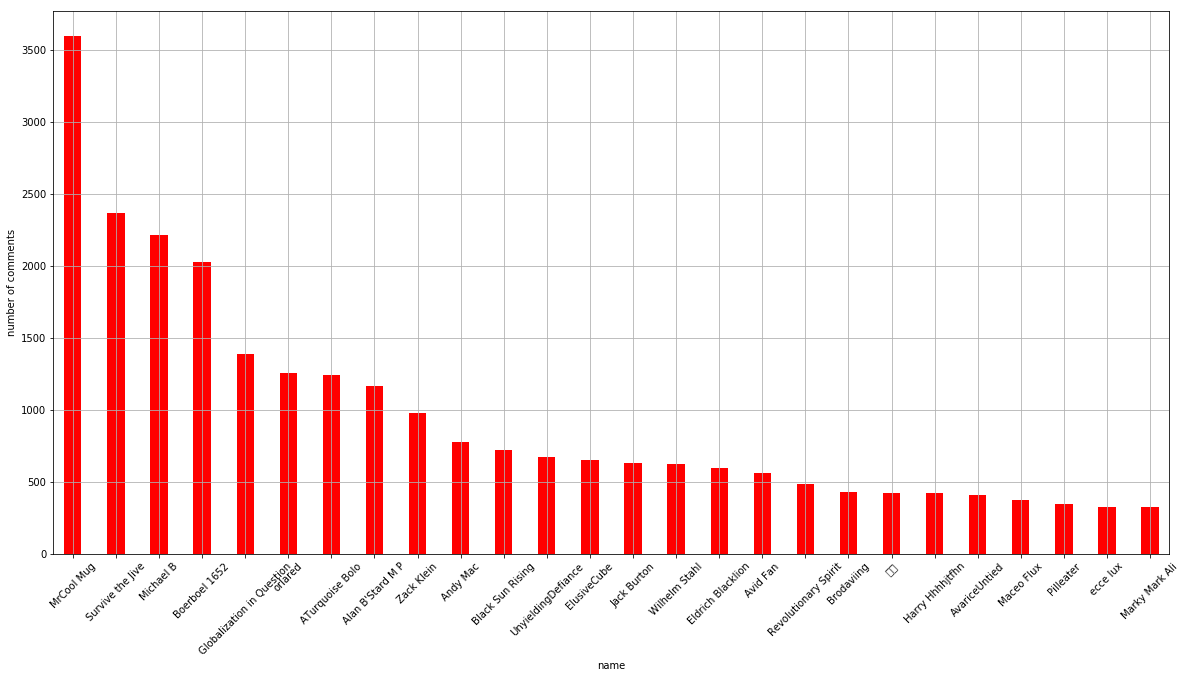

In [215]:
topcommenters = users_in_int_right.author_display_name.value_counts()
topcommenters_to_plot = topcommenters[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topcommenters_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

So these are the users of the channel we are interested in and how much they have commented on channels of the international right infosphere. Let's write this to a csv_file. 

In [216]:
topcommenters.to_csv(directory + name + '_most_prolific_commenters_int_right_infosphere.csv', index=True)

Look at the most popular channels of this group.

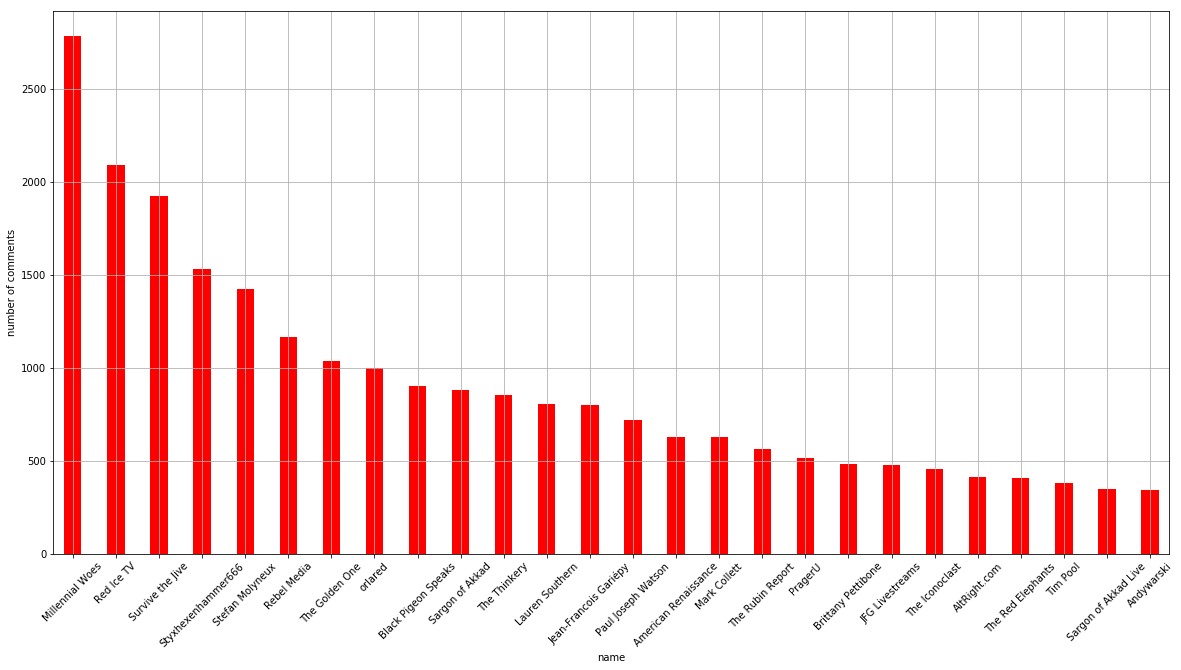

In [217]:
topchannels = users_in_int_right.video_channel_title.value_counts()
topchannels_to_plot = topchannels[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topchannels_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

So here we see the most popular channels of our user group. Let's write this list to a csv as well.

In [218]:
topchannels.to_csv(directory + name + '_most_popular_channels_int_right_infosphere.csv', index=True)

## Check if we find our users in the left wing infosphere

In [219]:
column_names = ['video_id',
      'comment_id',
      'author_display_name',
      'author_channel_url',
      'author_channel_id',
      'comment_text',
      'comment_like_count',
      'comment_dislike_count',
      'comment_time',
      'reply_count']

iter_csv = pd.read_csv(path_left + 'clean_comments_left.csv', 
                        iterator=True, 
                        chunksize=1000000, 
                        names=column_names,
                        sep='¶',
                        quotechar='þ',
                        engine='python')

nl_int_comment_sphere_left = pd.concat([chunk[chunk['author_channel_id'].isin(users)] for chunk in iter_csv])

# How many comments did we find?
len(nl_int_comment_sphere_left)

9159

In [220]:
column_names = ['video_id',
                      'video_published',
                      'channel_id',
                      'video_title',
                      'video_description',
                      'video_channel_title',
                      'video_tags',
                      'video_category_id',
                      'video_default_language',
                      'video_duration',
                      'video_view_count',
                      'video_comment_count',
                      'video_likes_count',
                      'video_dislikes_count',
                      'video_topic_ids',
                      'video_topic_categories']

videos_left = pd.read_csv('output/left/videos_left.csv', 
                            names=column_names,
                            sep='¶',
                            quotechar='þ',
                            engine='python'
                            ) 

In [221]:
users_in_int_left = pd.merge(nl_int_comment_sphere_left, videos_left, on='video_id', how='left')
users_in_int_left = users_in_int_left.sort_values('comment_time')

In [222]:
# And write to csv

users_in_int_left.to_csv(directory + name + '_commenters_in_int_left_infosphere.csv')

And plot some data. First the most prolific commenters. Second the most popular channels.

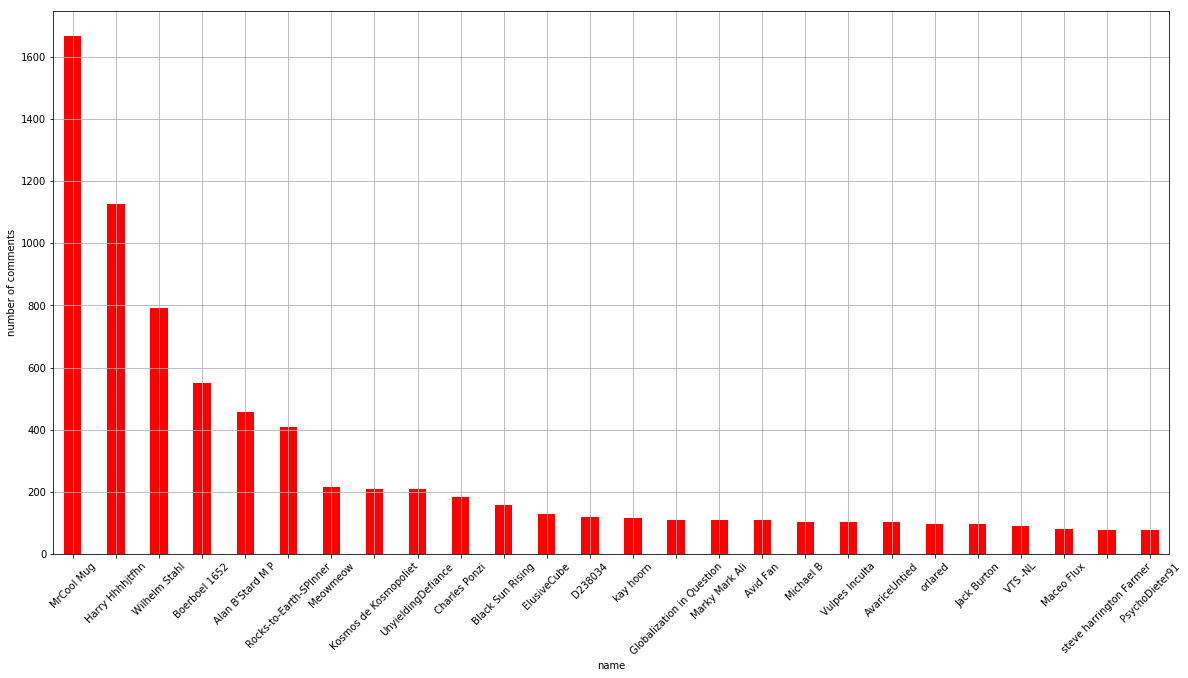

In [223]:
topcommenters = users_in_int_left.author_display_name.value_counts()
topcommenters_to_plot = topcommenters[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topcommenters_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

In [224]:
topcommenters.to_csv(directory + name + '_most_prolific_commenters_int_left_infosphere.csv', index=True)

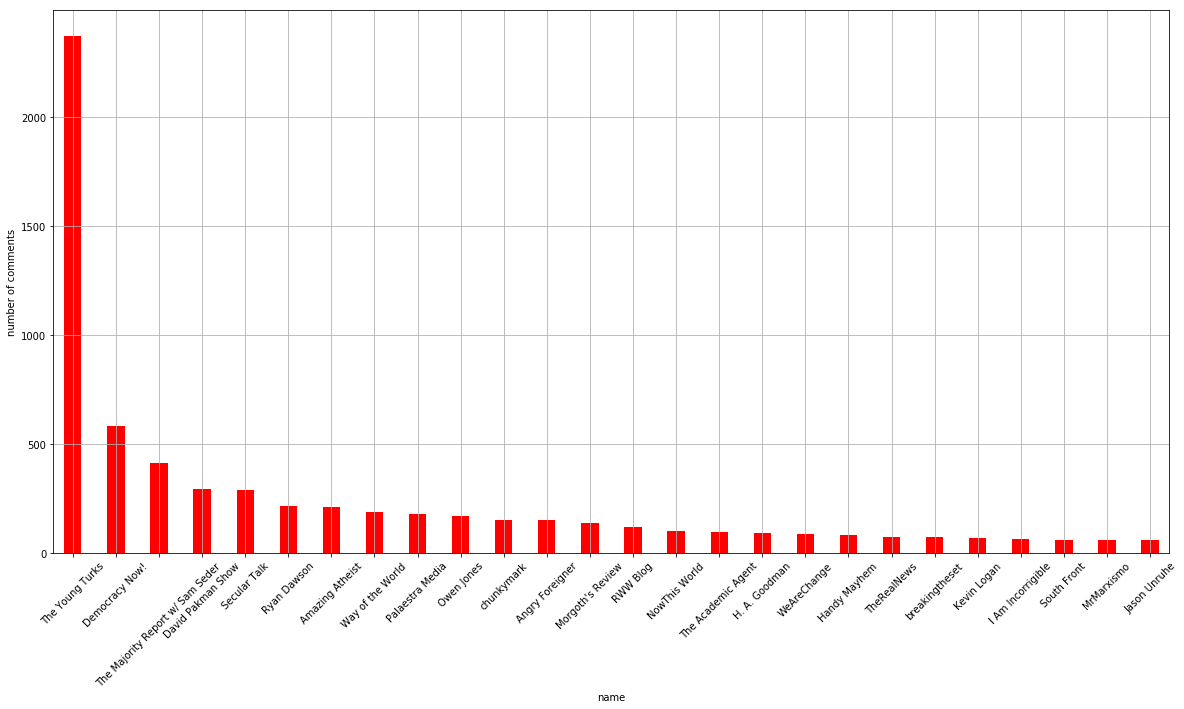

In [225]:
topchannels = users_in_int_left.video_channel_title.value_counts()
topchannels_to_plot = topchannels[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topchannels_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

In [226]:
topchannels.to_csv(directory + name + '_most_popular_channels_int_left_infosphere.csv', index=True)

## Now add all spheres together, so we get a complete picture of our users' activity

We have three groups:
1. users_in_nl
2. users_in_int_right
3. users_in_int_left

In [227]:
info_sphere = users_in_nl.append([users_in_int_left, users_in_int_right], sort=False)

# Write to csv

info_sphere.to_csv(directory + name + '_commenters_in_total_infosphere.csv')

# So how many comments do we have for our user group?
len(info_sphere)

48892

## Search by tags

In [ ]:
# If you need to load the data again, run this cell.

info_sphere = pd.read_csv(directory + name + '_commenters_in_total_infosphere.csv')

In [228]:
# Define the topic you want to investigate EUGENICS

query_topic = 'eugenics'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['race realis', 'race and iq', 'race iq',
         'charles murray', 'bell curve', 'jared taylor', 
         'eugenics', 'galton', 'genetic', '^dna$',
        'american rennai', 'ancestry', 'amren', '^iq$',
        '^intelligence$']


In [130]:
# Define the topic you want to investigate GENDER

query_topic = 'gender'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['femini', 'family',
         'sjw', 'social justice wa', 'social injustice wa', 
         'reproductive righ', 'patriarch', 'matriarch', 'mgtow',
         'metoo', '^rape', 'rape cultur', 'transgender', 'lhbt', 'lgbt', 'homosex',
         'lesbia', 'proud boys', 'incel', 'pickup arti', 'rooshv', '^women',
         'marriage', "men's right", 'men rights', 'manospher', '^gay$|gay\s|gays|lesbi',
         'gender', 'mascul', '^men$', 'hypergam', 'gynocentr', 'briffault', 'divorce',
         'prostitu', 'gold digg', 'whores', 'vagina', 'parasitic women', '^sex$', 'mens righ',
         '^dating$', 'sexis', 'alpha fucks', '^father$', 'relationship', 'mother', 
         'gamergate', 'misogy', 'female', 'revenge of the cis', 'sargon', 'sexual',
         'frauen', '^kinder$', '^trans$', 'misandry', '^girls$', 'queer', 'alfa fux'
        ]


In [64]:
# Define the topic you want to investigate REFUGEES & IMMIGRATION

query_topic = 'refugees_immigration'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['refugees', 'rapefugee', 'vlucht', 
         'asyl', 'asiel', 'asylu', 'gelukszoeke', 'flücht',
         'migrati', 'immigrat', 'migrant', 'immigrant', 'ausl',
         'frontex', 'border', 'azc', 'replacement', 'replace', 
         'kalergi', 'omvolking', 'integrat', 'invasion', 'invasie',
         'demograf', 'demograph'
        ]


In [ ]:
# Define the topic you want to investigate ISLAM

query_topic = 'islam'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['calipha', 'jihad', 'islamis', 'islamic',
         'burqa', 'burka', 'prophet', 'muhamm', 'mohamm', '^islam$',
         'counter-jiha', 'counter jiha', 'contra jiha', 'contra-jiha',
         'kopvod', 'muslim', 'quran', 'koran', 'mosque', 'moskee',
        '^isis$', 'al qaed', 'al-qaed', 'infidel', 'dhimmi', 'sharia', 'robert spence',
        'tommy rob', '^is$', '^isil$', '^imam$', 'moschee', 'dawah', 'salaf']

In [ ]:
# Define the topic you want to investigate SJW

query_topic = 'sjw'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['sjw', 'identity politi', 'identiteitspol', 'black lives matter',
         'blm', 'femini', 'lhbt', 'justice warr', 'injustice warr', 'cultural marxi', 'diversit'
        ]

In [139]:
query_topic = 'antisemitism'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['holoh', 'holoc', 'jq', 'jewi', 'jews', '^jew$', 
         'soros', 'goy', 'schlom', 'shekel', 'cultural marxi',
         'national social', 'nazis', 'national sozia', 'jood', 'joden',
         'juif', 'jude', 'jiddis', 'zog', 'new world order', 'nwo', 'zionis', 'zion wa', 'david duke', 'kkk',
         'hitler', 'antisemi', 'yahweh', 'frankfurt sch'

        ]

In [148]:
query_topic = 'race'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['black lives matter', 'blm', 'white lives matter', 'wlm',
         'white genoci', 'replacement', '^race$', 'racist', 'rassis', 
         'racial', '^black$', 'diversity', 'richard spenc',
         '^white$', 'david duke', 'kkk', 'black peop', 'slaver',
         'greg johns', '^blacks$', 'white ident', 'antiwhite', 'michael brown', 
         'white guilt', 'white privil', 'white suprema', '^realist$',
         '^ethnic', 'affirmative act', 'multiculturali'
        ]

In [ ]:
query_topic = 'philosophy'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['traditionalism', 'esoteric', 'theosoph', '^pagan', 'romanticis',
         'nouvelle droi', 'alexander dugi', 'metapoliti', 'fascis', 'occult', 
         
        ]

In [ ]:
query_topic = 'libertarianism'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['liberatar', '^mises', 'objectivis', '^ayn$', 'ayn rand', 'rand pa',
         'free market', 'reason.tv', 'reason foun', 'reasontv', 'reason.org', 
         'neoreact', 'nrx', 'rothbard'
         
         
        ]

In [229]:
pattern = '|'.join([s for s in query])
mask = info_sphere['video_tags'].str.contains(pattern, regex=True, case=False, na=False)
result = info_sphere[mask]

len(result)

1870

In [230]:
# Write to csv in separate folder

directory_topics = path_users + name + '/' + query_topic + "/"

if not os.path.exists(directory_topics):
    os.makedirs(directory_topics)
    
result.to_csv(directory_topics + 'commenters_of_' + name + '_commenting_on_videos_about_' + query_topic + '.csv')

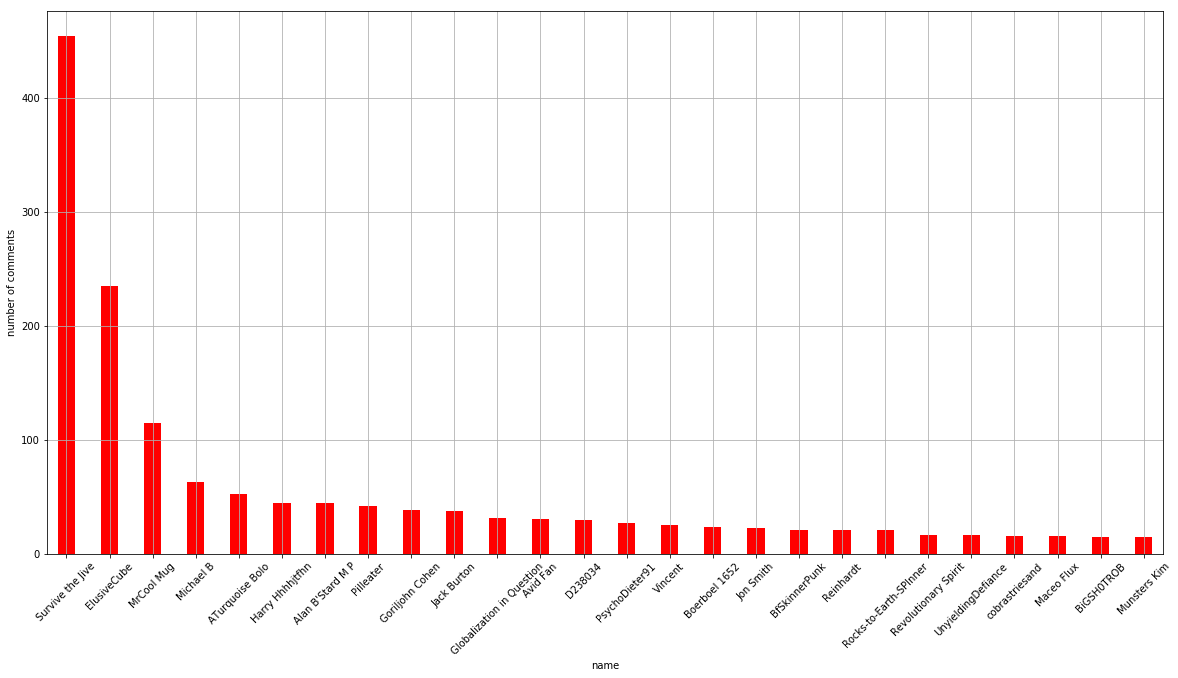

In [231]:
topcommenters = result.author_display_name.value_counts()
topcommenters_to_plot = topcommenters[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topcommenters_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

In [232]:
topcommenters.to_csv(directory_topics + 'most_prolific_commenters_of_' + name + '_commenting_on_videos_about_' + query_topic + '.csv', index=True)

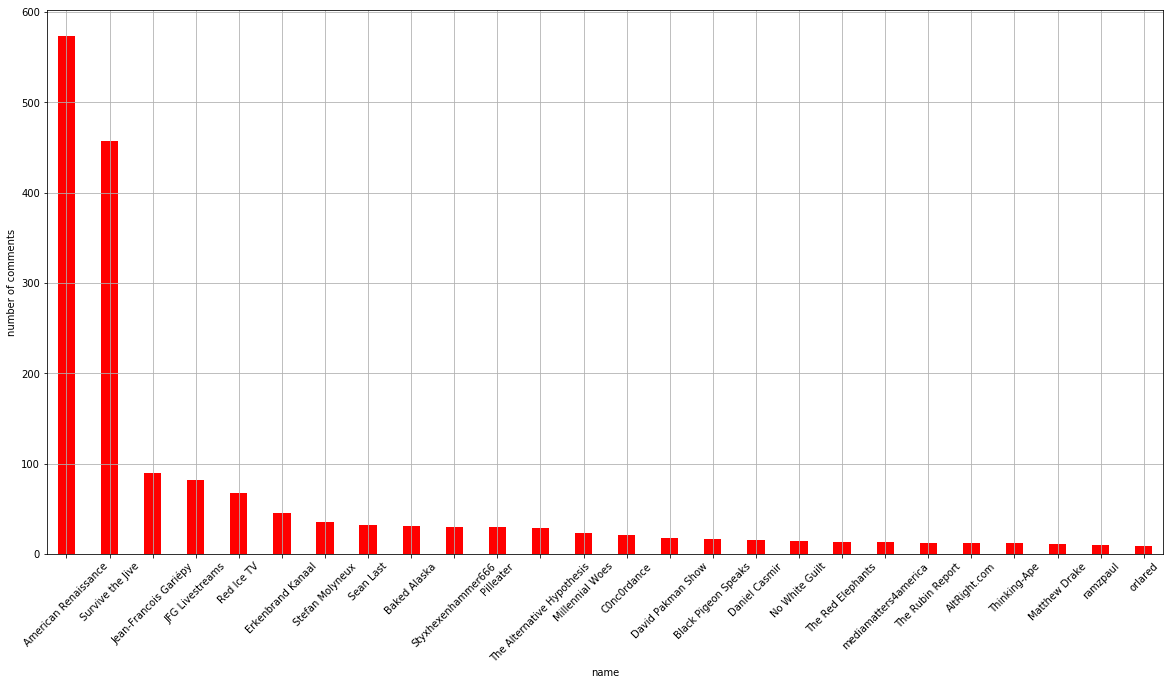

In [233]:
topchannels = result.video_channel_title.value_counts()
topchannels_to_plot = topchannels[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topchannels_to_plot.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

In [234]:
topchannels.to_csv(directory_topics + 'most_commented_on_channels_by_' + name + '_about_' + query_topic + '.csv', index=True)

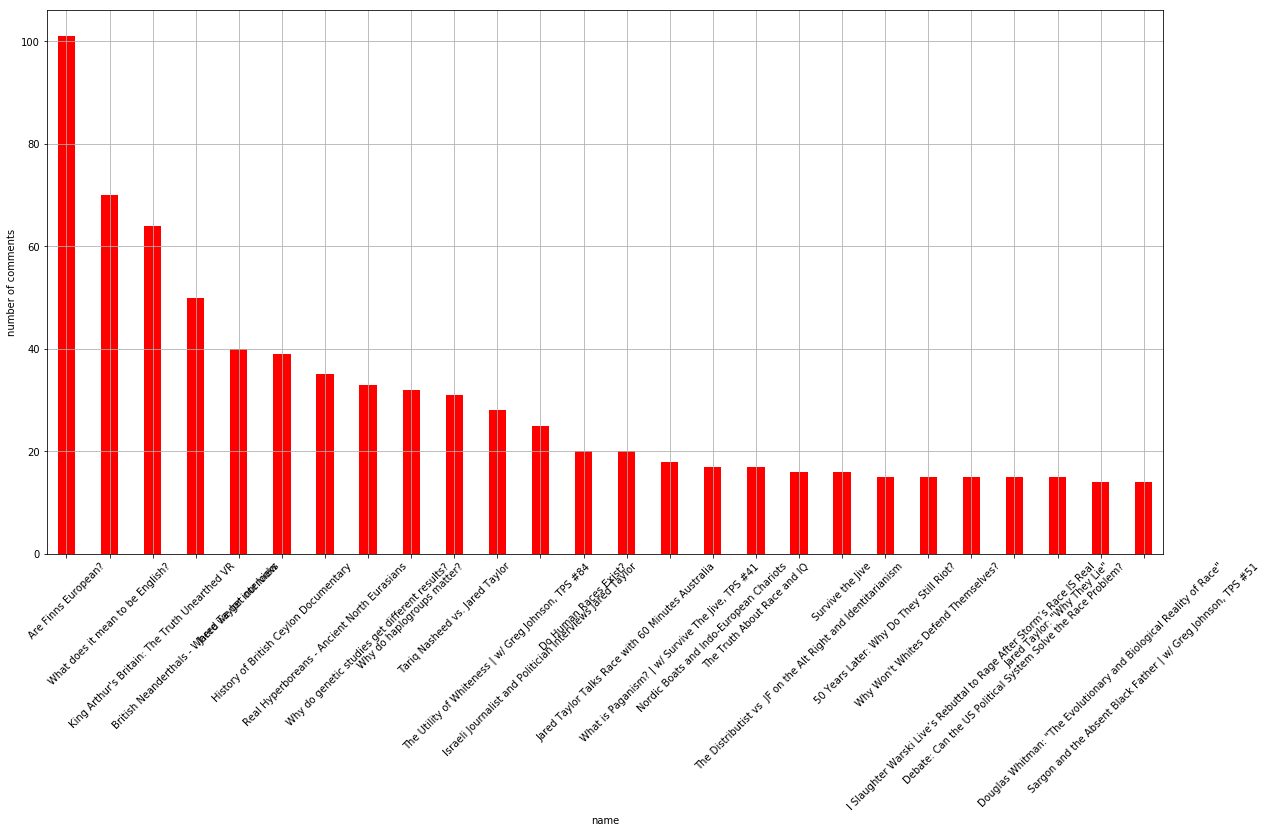

In [235]:
topvideos = result.video_title.value_counts()
topvideos = topvideos[0:26]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = topvideos.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('name')
plt.xticks(rotation=45)

plt.show()

In [236]:
topvideos.to_csv(directory_topics + 'most_commented_on_videos_by_' + name + 'about_' + query_topic + '.csv', index=True)

## Prepare data for graph

In [ ]:
result.columns

In [ ]:
for_graph = result[['author_display_name', 'video_channel_title', 'comment_time']]

In [ ]:
for_graph['year'] = for_graph['comment_time'].str[0:4]

In [ ]:
for_graph = for_graph.rename(columns={'author_display_name': 'Source',
                             'video_channel_title': 'Target',
                             'year': 'Start'})

In [ ]:
for_graph.to_csv(directory + 'for_gephi_commenters_channels.csv', index=False)

### Find data of subset of users with Dutch sounding names

In [ ]:
# Some people with Dutch sounding names 
# who have commented on more than 10 channels in the international network

nl_of_interest_int = ['A Stuijt',
                    'Adrie Van Dijk',
                    'Akka Fietje',
                    'Wouter Lensvelt',
                    'Willem Sterk',
                    'Michael Groenendijk',
                    'Milo Overzicht',
                    'Mike De Jong',
                    'Mike Brink',
                    'Nellie Rutten',
                    'Paul van Dijck',
                    'Peter Jongsma',
                    'Piet Hein',
                    'Pieter van der Meer',
                    'Polder Cannabis Olie team',
                    'Politiekman',
                    'Raymond Doetjes',
                    'Willem Pasterkamp',
                    'Wimpiethe3',
                    'Willie van het Kerkhof',
                    'Vincent Vermeer',
                    'Mark Tak',
                    'Melvin Jansen',
                    'Mark Kamphuis',
                    'Tristan van Oosten',
                    'Tom dGe-lugs-pa',
                    'Tom Van de Pol',
                    'Tom Van Gool',
                    'Marcel Bruinsma',
                    'Maarten van der Poel',
                    'Maciano Van der Laan',
                    'Tiemen Weistra',
                    'TheRdamterror',
                    'TheCitroenman1',
                    'The flying dutchman',
                    'Teun de Heer',
                    'Stijn van de Ven',
                    'Sjaak v Koten',
                    'Sev Vermeer',
                    'Tanya De Beer',
                    'Tim Pietersen',
                    'Alan Holland',
                    'Bennie Leip',
                    'Bert Prins',
                    'Bestheftig',
                    'Borisje Boef',
                    'Chris Van Bekkum',
                    'Coen Bijpost',
                    'Cornelis van der Heijden',
                    'David Teunissen',
                    'David Van der Tweel',
                    'De Veelvraat',
                    'Dennis Bouma',
                    'Dennis Eijs',
                    'Donald gekkehenkie',
                    'peter van',
                    'onbekende telefoon',
                    'nick van achthoven',
                    'mikedehoogh black flag race photos',
                    'kristof verbruggen',
                    'jan holdijk',
                    'jan Yup',
                    'iwan munnikes',
                    'hans van de mortel',
                    'geroestetumor',
                    'geheimschriver',
                    'gaatje niksaan',
                    'dutchmountainsnake',
                    'dutch menneer',
                    'donder bliksem',
                    'boereriem',
                    'appie D',
                    'adam willems',
                    'Yuri Klaver',
                     'zuigdoos',
                    'yvonneforsmanatyahoo',
                    'vanhetgoor',
                    'theflyingdutchboi',
                    'r juttemeijer',
                    'rutger houtdijk',
                    'Dutch Patriot',
                    'Dutch Whitey',
                    'DutchFurnace',
                    'Esias Lubbe',
                    'Ewalds Eiland',
                    'Joey Kuijs',
                    'Faust',
                    'Hollandia777',
                    'Johan van Oldenbarnevelt',
                    'Keescanadees',
                    'Geert Kok',
                    'Haasenpad',
                    'Henk Damster',
                    'Henk van der Laak',
                    'Henri Zwols',
                    'Haat Praat',
                    'Gerard Mulder',    
                    'Grootmeester Jan',
                    'H. v. Heeswijk',
                    'B. Hagen',
                    '1234Daan4321',
                    'Daniella Thoelen', 
                    'Diederik',
                    'Linda Bostoen', 
                    'Christiaan Baron', 
                    'Matthijs van Guilder',
                    'Johannes Roose',
                    'Deon Van der Westhuizen', 
                    'Remko Jerphanion', 
                    'Roosje Keizer',
                    'Dennis Durkop',
                    'ivar olsen',
                    'Pete de pad',
                    'georgio jansen',
                    'Joel Peter',
                    'Antonie de Vry',
                    'Stijn Voorhoeve', 
                    'liefhebber179',
                    'Walter Taljaard',
                    'joe van gogh',
                    'Edo Peter', 
                    'Ad Lockhorst',
                    'kay hoorn',
                    'Erik Bottema',
                    'Deplorable Data',
                    'JESSEverything',
                    'Harry Balzak', 
                    'Bokkepruiker Records',
                    'zonnekat',
                    'Peter-john De Jong',
                    'marco mac',
                    'Joubert x',
                    'Natasja van Dijk',
                    'Voornaam Achternaam',
                    'hermanPla', 
                    'M. van der Scheer',
                    'gerald polyak',
                    'Robbie Retro',
                    'Johannes DeMoravia',
                    'Wouter Vos',
                    'AwoudeX',
                    'carolineleiden',
                    'A-dutch-Z',
                    'piet ikke',
                    'kutbleat',
                    'David of Yorkshire',
                    'Gert Tjildsen',
                    'Flying Dutchman',
                    'Visko Van Der Merwe',
                    'Blobbejaan Blob',
                    'TheBergbok',
                    'jknochel76',
                    'Olleke Bolleke'
                    ]

# And top n from nl_most prolific commenters (on 10 Dutch channels or more, with 150 comments or more)

nl_of_interest_nl = ['Nayako Sadashi', 'demarcation'  
                    'er zaal',
                    'jhon jansen',
                    '-____-',
                    'Brummie Brink',
                    'reindeerkid ',
                    'Pagan Cloak',
                    'NDY',
                    'Karel de Kale',
                    'top top',
                    'Chris Veenendaal ',
                    'MijnheerlijkeBuitenlandse befkut ,',
                    'Kevin Zilverberg',
                    'Rick Dekker ',
                    'Adrie Van Dijk ',
                    'miep miep',
                    'pronto ',
                    'TheUnTrustable0',
                    'danny schaap',
                    'Mark Mathieu',
                    'Raysboss302',
                    'Ruud Hooreman',
                    'Willie W',
                    'Barend Borrelworst',
                    'theo breytenbach',
                     'coinmaster1000 coinmaster1000'  ]

### Show radicalisation paths

In [ ]:
# Fill in the author display name of the person you are interested in.

person_of_interest = ''

poi = result[result['author_display_name'] == person_of_interest ]

# You can also use the author_channel_id if you want to be sure you are dealing with the same person
# Both have to be 1. 

poi.author_display_name.nunique()

In [ ]:
poi.author_channel_id.nunique()

In [ ]:
p = poi.groupby(['year','video_channel_title']).size()

p.to_csv(path_nl + 'temp_data/for_raw_graph_woutervos.csv')